# Super Learner
Demonstration of super learning outperforming other common regression methods.

For my example, I created a hard to learn functional form (part continuous, part step-function). I compare linear regression with various 

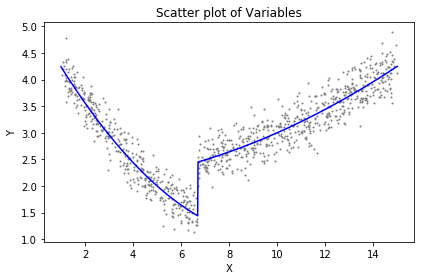

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from zepid import spline

import supylearner
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

n = 1000
np.random.seed(2019640)

# TRUE FUNCTIONAL FORM
x = np.linspace(1, 15, 1000)
y = np.where(x < 6.7, 1, 0)*(((x - 10)/5)**2 + 1) + np.where(x >= 6.7, 1, 0)*((0.1*x)**2 + 2)

# Simulating up some hot data
df = pd.DataFrame()
df['X'] = np.random.uniform(1, 15, size=n)
df['Y'] = (np.where(df['X'] < 6.7, 1, 0)*(((df['X'] - 10)/5)**2 + 1) +
           np.where(df['X'] >= 6.7, 1, 0)*((0.1*df['X'])**2 + 2) +
           np.random.normal(0, 0.25, size=n))
# Sorting to ease display purposes for myself
df.sort_values(by='X', inplace=True)

# Scatter plot of Results
plt.plot(df['X'], df['Y'], linestyle='', marker='o', markersize=1, color='gray')
plt.plot(x, y, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of Variables')
plt.tight_layout()
plt.show()

Below is a comparison of several standard methods. I include OLS with up to 5th order terms, OLS with restricted cubic splines, and LOESS. As you will see in the plots, super learner better matches the true data generating distribution than any of the other methods

In [6]:
df['x_sq'] = df['X']**2
df['x_cu'] = df['X']**3
df['x_qu'] = df['X']**4
df['x_fi'] = df['X']**5
df[['x_sp1', 'x_sp2', 'x_sp3']] = spline(df, var='X', term=3, n_knots=4, restricted=True)
df['xc'] = np.round(df['X'], 0)

# Ordinary Least Squares models
ols1 = smf.ols('Y ~ X', df).fit()
ols2 = smf.ols('Y ~ X + x_sq', df).fit()
ols3 = smf.ols('Y ~ X + x_sq + x_cu', df).fit()
ols4 = smf.ols('Y ~ X + x_sq + x_cu + x_qu', df).fit()
ols5 = smf.ols('Y ~ X + x_sq + x_cu + x_qu + x_fi', df).fit()
ols6 = smf.ols('Y ~ X + x_sp1 + x_sp2 + x_sp3', df).fit()
ols7 = smf.ols('Y ~ C(xc)', df).fit()

# LOESS
for_loess = df.groupby(by='xc').mean()
yl = lowess(list(for_loess['Y']), list(for_loess.index), frac=0.2)
lowess_x = list(zip(*yl))[0]
lowess_y = list(zip(*yl))[1]

# Super Learner
xvars = np.asarray(df[['X']])
neu1 = MLPRegressor(hidden_layer_sizes=(2,), random_state=1463, max_iter=500)
lin1 = LinearRegression()
randf = RandomForestRegressor(n_estimators=100)
knn1 = KNeighborsRegressor(n_neighbors=5)
svm = SVR()

lib = [neu1, lin1, knn1, svm, randf]
libnames = ["NNet", "LinReg", "KNN", "SVM", "RandomForest"]
sl = supylearner.SuperLearner(lib, libnames, K=5, print_results=False)
sl.fit(X=xvars, y=np.asarray(df['Y']))
print(sl.summarize())
ystar = sl.predict(X=xvars)


Cross-validated risk estimates for each estimator in the library:
[['NNet' '1.1001727509096877']
 ['LinReg' '1.4997733378507012']
 ['KNN' '0.44342272834049806']
 ['SVM' '0.41849678881607655']
 ['RandomForest' '0.5505526136401597']]

Coefficients:
[['NNet' '0.0']
 ['LinReg' '0.0']
 ['KNN' '0.45209520755860816']
 ['SVM' '0.5479047924413919']
 ['RandomForest' '0.0']]

(Not cross-valided) estimated risk for SL: 0.3653224387037861
None


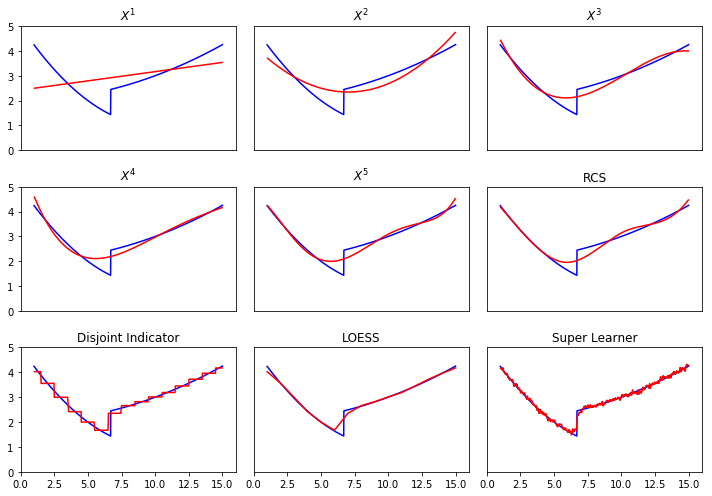

In [7]:
plt.figure(figsize=(10, 7))
plt.subplot(331)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols1.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.xticks([])
plt.title('$X^1$')

plt.subplot(332)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols2.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.yticks([])
plt.xticks([])
plt.title('$X^2$')

plt.subplot(333)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols3.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.yticks([])
plt.xticks([])
plt.title('$X^3$')

plt.subplot(334)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols4.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.xticks([])
plt.title('$X^4$')

plt.subplot(335)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols5.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.yticks([])
plt.xticks([])
plt.title('$X^5$')

plt.subplot(336)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols6.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.yticks([])
plt.xticks([])
plt.title('RCS')

plt.subplot(337)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ols7.predict(df), color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.title('Disjoint Indicator')

plt.subplot(338)
plt.plot(x, y, color='blue')
plt.plot(lowess_x, lowess_y, color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.yticks([])
plt.title('LOESS')

plt.subplot(339)
plt.plot(x, y, color='blue')
plt.plot(df['X'], ystar, color='r')
plt.xlim([0, 16])
plt.ylim([0, 5])
plt.yticks([])
plt.title('Super Learner')
plt.tight_layout()
plt.show()